# 데이터 살펴보기

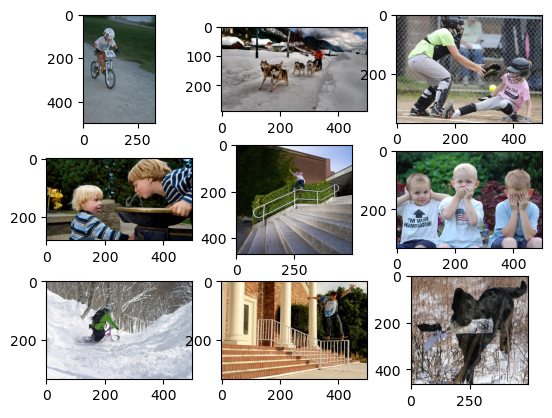

In [1]:
import glob
import matplotlib.pyplot as plt

from PIL import Image
imgs = glob.glob('/home/restful3/datasets_local/Flickr8k/CH09/*.jpg')
for i in range(9):
    img = Image.open(imgs[i])
    plt.subplot(3,3,1+i)
    plt.imshow(img)
plt.show()    

# 학습용 데이터셋 만들기

In [2]:
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset

def rgb2lab(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

In [3]:
def lab2rgb(lab):
    return cv2.cvtColor(lab,cv2.COLOR_LAB2RGB)

- 교재의 코드에서 Image.open(self.data[i]).resize(256, 256) 부분에서 이미지를 리사이즈할 때 사용되는 필터가 256로 지정되어 있습니다. 그러나 올바른 필터는 Image.Resampling.NEAREST, Image.Resampling.LANCZOS, Image.Resampling.BILINEAR, Image.Resampling.BICUBIC, Image.Resampling.BOX, Image.Resampling.HAMMING 중 하나여야 합니다.

- 해결하기 위해서는 resize 메서드에서 올바른 필터를 사용해야 합니다. 예를 들어 Image.Resampling.BICUBIC 필터를 사용하려면 다음과 같이 코드를 수정할 수 있습니다.

In [4]:
class AutoColoring(Dataset):
    def __init__(self):
        self.data = glob.glob('/home/restful3/datasets_local/Flickr8k/CH09/*.jpg')
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
#         rgb = np.array(Image.open(self.data[i]).resize(256, 256))
        rgb = np.array(Image.open(self.data[i]).resize((256, 256), resample=Image.Resampling.BICUBIC))

        lab = rgb2lab(rgb)
        # 채널 차원이 가장 앞에 오도록 변경
        lab = lab.transpose((2, 0, 1)).astype(np.float32)
        
        return lab[0], lab[1:] # LAB에서, L 에 해당하는 것이 흑백, 입력

# 모델 정의하기 : 로 레벨 특징 추출기

In [5]:
import torch
import torch.nn as nn

class LowLevel(nn.Module):
    def __init__(self):
        super(LowLevel, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid()
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid()
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid()
        )  
    def forward(self, x):
        low = self.block1(x)
        low = self.block2(low)
        low = self.block3(low)
        low = self.block4(low)
        low = self.block5(low)
        low = self.block6(low)
        return low

# 모델 정의하기 : 미들 레벨 특징 추출기

In [6]:
class MidLevel(nn.Module):
    def __init__(self):
        super(MidLevel, self).__init__()
        self.mid1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid()
        )
        self.mid2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid()            
        )        
    def forward(self, x):
        mid = self.mid1(x)
        mid = self.mid2(mid)
        
        return mid

# 모델 정의하기 : 글로벌 레벨 특징 추출기

In [7]:
class GlobalLevel(nn.Module):
    def __init__(self):
        super(GlobalLevel, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid()            
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid()            
        )   
        self.fc = nn.Sequential(
            nn.Linear(in_features=32768, out_features=1024),
            nn.Sigmoid(),            
            nn.Linear(in_features=1024, out_features=512),            
            nn.Sigmoid(),            
            nn.Linear(in_features=512, out_features=256),
            nn.Sigmoid()            
        )
        
    def forward(self, x):
        glo = self.block1(x)
        glo = self.block2(glo)        
        glo = self.block3(glo)        
        glo = self.block4(glo)     
        glo = torch.flatten(glo, start_dim=1)
        glo = self.fc(glo)
        
        return glo

# 모델 정의하기 : 컬러라이제이션 신경망

In [8]:
class Colorization(nn.Module):
    def __init__(self):
        super(Colorization, self).__init__()
        
        self.color1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                               kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid()
        )
        
        self.color2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Sigmoid()            
        )
        
        self.color3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, 
                               kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid()            
        )
        
        self.color4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                               kernel_size=2, stride=2), # default padding size is zero
            nn.BatchNorm2d(32),
            nn.Sigmoid() 
        )        
        
        self.color5 = nn.ConvTranspose2d(in_channels=32, out_channels=2, 
                               kernel_size=2, stride=2) # 마지막은 AB 채널 2개
        
    def forward(self, x):
        color = self.color1(x)
        color = self.color2(color)
        color = self.color3(color)
        color = self.color4(color)
        color = self.color5(color)        
        
        return color

# 모델 정의하기 : 전체 모델

In [9]:
class AutoColoringModel(nn.Module):
    def __init__(self):
        super(AutoColoringModel, self).__init__()
        self.low = LowLevel()
        self.mid = MidLevel()
        self.glo = GlobalLevel()
        self.fusion = nn.Conv2d(in_channels=512, out_channels=256,
                               kernel_size=3, stride=1, padding=1)
        self.color = Colorization()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        low = self.low(x)
        
        mid = self.mid(low)
        glo = self.glo(low)
        
        fusion = glo.repeat(1, mid.shape[2]*mid.shape[2])
        fusion = torch.reshape(fusion, (-1, 256, mid.shape[2], mid.shape[2]))
        
        fusion = torch.cat([mid, fusion], dim=1)
        fusion = self.fusion(fusion)
        fusion = self.sigmoid(fusion)
        
        color = self.color(fusion)
        
        return color

# 모델 학습하기

In [10]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
model = AutoColoringModel().to(device)

dataset = AutoColoring()
loader = DataLoader(dataset, batch_size=32, shuffle=True)
optim = Adam(params=model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [12]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for L, AB in iterator:
        L, AB = L.to(device), AB.to(device)
        L = torch.unsqueeze(L, dim=1).to(device)
        optim.zero_grad()
        pred = model(L)
        
        loss = loss_fn(pred, AB)
        loss.backward()
        optim.step()
        
        iterator.set_description(f'epoch : {epoch+1}, loss : {loss.item()}')
        
torch.save(model.state_dict(), './models/AutoColor.pth')        

epoch : 101, loss : 159.3199920654297: 100%|██| 253/253 [01:04<00:00,  3.90it/s]


epoch : 200, loss : 122.65701293945312: 100%|█| 253/253 [01:05<00:00,  3.85it/s]


# 모델 성능 평가하기

In [14]:
test_L, test_AB = dataset[0]
test_L = np.expand_dims(test_L, axis=0)
real_img = np.concatenate([test_L, test_AB])
real_img = real_img.transpose(1, 2, 0).astype(np.uint8)
real_img = lab2rgb(real_img)

In [22]:
with torch.no_grad():
    model.load_state_dict(
        torch.load('./models/AutoColor.pth', map_location=device)
    )
    input_tensor = torch.tensor(test_L)
    input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
    pred_AB = model(input_tensor)
    
    pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
    pred_LAB = torch.squeeze(pred_LAB)
    pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()
    pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))    

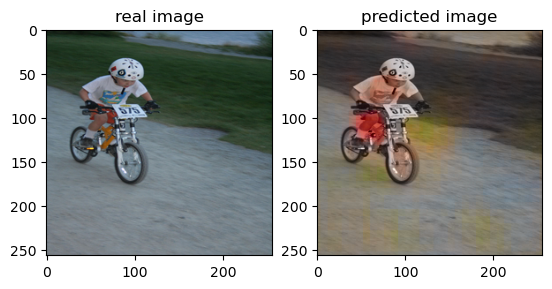

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.title('real image')

plt.subplot(1, 2, 2)
plt.imshow(pred_LAB)
plt.title('predicted image')

plt.show()